In [18]:
import pickle
import numpy as np
import pandas as pd

# Load these embeddings from the pickle files
train_embeddings_file = "train_embeddings.pkl"
val_embeddings_file = "val_embeddings.pkl"

train_embeddings_loaded = pickle.load(open(train_embeddings_file, "rb"))
val_embeddings_loaded = pickle.load(open(val_embeddings_file, "rb"))

In [19]:
# Load the labels from the pickle files
task2_train_labels = "task2_labels_train.pkl"
task2_val_labels = "task2_labels_dev.pkl"

task2_train_labels_loaded = pickle.load(open(task2_train_labels, "rb"))
task2_val_labels_loaded = pickle.load(open(task2_val_labels, "rb"))

In [20]:
# # For each key, pad the embeddings and labels to the maximum length of 24
# # Pad the embeddings with zeros and the labels with -1
# max_length = 24

# for key in train_embeddings_loaded.keys():
#     if len(train_embeddings_loaded[key]) < max_length:
#         train_embeddings_loaded[key] = np.concatenate((train_embeddings_loaded[key], np.zeros((max_length - len(train_embeddings_loaded[key]), 384))))
#         task1_train_labels_loaded[key] = np.concatenate((task1_train_labels_loaded[key], np.full((max_length - len(task1_train_labels_loaded[key])), -1)))

# for key in val_embeddings_loaded.keys():
#     if len(val_embeddings_loaded[key]) < max_length:
#         val_embeddings_loaded[key] = np.concatenate((val_embeddings_loaded[key], np.zeros((max_length - len(val_embeddings_loaded[key]), 384))))
#         task1_val_labels_loaded[key] = np.concatenate((task1_val_labels_loaded[key], np.full((max_length - len(task1_val_labels_loaded[key])), -1)))

In [21]:
# Get all unique labels
unique_labels = set()
for key in task2_train_labels_loaded.keys():
    # Check for None values and change them to 0
    for i in range(len(task2_train_labels_loaded[key])):
        if task2_train_labels_loaded[key][i] == None:
            task2_train_labels_loaded[key][i] = 0
    unique_labels.update(task2_train_labels_loaded[key])


for key in task2_val_labels_loaded.keys():
    # Check for None values and change them to 0
    for i in range(len(task2_val_labels_loaded[key])):
        if task2_val_labels_loaded[key][i] == None:
            task2_val_labels_loaded[key][i] = 0
    unique_labels.update(task2_val_labels_loaded[key])

print(unique_labels)

{0.0, 1.0}


In [22]:
# Convert embeddings to lists
train_embeddings = [train_embeddings_loaded[key] for key in train_embeddings_loaded.keys()]
val_embeddings = [val_embeddings_loaded[key] for key in val_embeddings_loaded.keys()]

In [23]:
# convert labels to lists
train_labels = [task2_train_labels_loaded[key] for key in task2_train_labels_loaded.keys()]
val_labels = [task2_val_labels_loaded[key] for key in task2_val_labels_loaded.keys()]

# Convert labels to integers
train_labels = [[int(label) for label in labels] for labels in train_labels]
val_labels = [[int(label) for label in labels] for labels in val_labels]

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader

class EmotionDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings  # List of embedding matrices
        self.labels = labels  # List of label arrays

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return torch.tensor(self.embeddings[idx]), torch.tensor(self.labels[idx], dtype=torch.long)
    
def collate_fn(batch):
    embeddings, labels = zip(*batch)
    embeddings_pad = torch.nn.utils.rnn.pad_sequence(embeddings, batch_first=True, padding_value=0)
    labels_pad = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=-1)  # Use 0 for padding
    return embeddings_pad, labels_pad

In [25]:
# Make train dataset and dataloader
train_dataset = EmotionDataset(train_embeddings, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Make val dataset and dataloader
val_dataset = EmotionDataset(val_embeddings, val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [26]:
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUModel, self).__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        output, _ = self.rnn(x)
        output = self.fc(output)
        return output

In [27]:
# Initialize the model
INPUT_SIZE = 384 # Dimension of the input embeddings
HIDDEN_SIZE = 128 # Dimension of the hidden state
OUTPUT_SIZE = 2 # Number of classes

model = GRUModel(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)

In [28]:
# Define the loss function and optimizer
from torch.optim import Adam

loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = Adam(model.parameters(), lr=0.001)

In [29]:
# Compute F1 metrics
from sklearn.metrics import f1_score

# Predictions and labels should be flattened arrays
def compute_metrics(predictions, labels):
    # Ignore the padding value -1 
    # Also ignore where both the prediction and label are 0
    mask = (labels != -1) & ((labels != 0) | (predictions != 0))
    masked_labels = labels[mask]
    masked_predictions = predictions[mask]

    if len(masked_labels) == 0 or len(masked_predictions) == 0:
        #print("Warning: No valid data points were found after masking. Returning zero F1 scores.")
        return 0.0, 0.0
    
    weighted_f1 = f1_score(masked_labels, masked_predictions, average='weighted')
    macro_f1 = f1_score(masked_labels, masked_predictions, average='macro')
    f1 = f1_score(masked_labels, masked_predictions)
    return weighted_f1, macro_f1, f1

In [30]:
# Train the model
num_epochs = 20

train_f1s = []
val_f1s = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Train the model
    model.train()
    train_loss = 0
    train_predictions = []
    train_labels = []

    for embeddings, labels in train_dataloader:
        optimizer.zero_grad()
        output = model(embeddings)
        
        # Flatten the output and labels
        output = output.view(-1, output.shape[-1]) # (batch_size * max_length, num_classes)
        labels = labels.view(-1)

        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Get the predictions
        predictions = output.argmax(dim=-1)

        train_predictions.append(predictions.detach().cpu().numpy())
        train_labels.append(labels.detach().cpu().numpy())

    train_predictions = np.concatenate(train_predictions)
    train_labels = np.concatenate(train_labels)
    train_loss /= len(train_dataloader)

    weighted_f1, macro_f1, f1 = compute_metrics(train_predictions, train_labels)

    train_f1s.append(f1)
    train_losses.append(train_loss)

    # Evaluate the model on the validation set
    model.eval()
    val_loss = 0
    val_predictions = []
    val_labels = []

    with torch.no_grad():
        for embeddings, labels in val_dataloader:
            output = model(embeddings)
            
            # Flatten the output and labels
            output = output.view(-1, output.shape[-1])
            labels = labels.view(-1)

            loss = loss_fn(output, labels)
            val_loss += loss.item()

            # Get the predictions
            predictions = output.argmax(dim=-1)

            val_predictions.append(predictions.detach().cpu().numpy())
            val_labels.append(labels.detach().cpu().numpy())

    val_predictions = np.concatenate(val_predictions)
    val_labels = np.concatenate(val_labels)

    val_loss /= len(val_dataloader)

    weighted_f1_val, macro_f1_val, f1_val = compute_metrics(val_predictions, val_labels)

    val_f1s.append(f1_val)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train F1: {f1:.4f}, Train Weighted F1: {weighted_f1:.4f}, Train Macro F1: {macro_f1:.4f}, Val Loss: {val_loss:.4f}, Val F1: {f1_val:.4f}, Val Weighted F1: {weighted_f1_val:.4f}, Val Macro F1: {macro_f1_val:.4f}")

Epoch 1/20
Train Loss: 0.3667, Train F1: 0.0878, Train Weighted F1: 0.0810, Train Macro F1: 0.0439, Val Loss: 0.3158, Val F1: 0.2236, Val Weighted F1: 0.1873, Val Macro F1: 0.1118
Epoch 2/20
Train Loss: 0.3230, Train F1: 0.2875, Train Weighted F1: 0.2354, Train Macro F1: 0.1437, Val Loss: 0.3037, Val F1: 0.4424, Val Weighted F1: 0.3235, Val Macro F1: 0.2212
Epoch 3/20
Train Loss: 0.3003, Train F1: 0.4845, Train Weighted F1: 0.3902, Train Macro F1: 0.2423, Val Loss: 0.2670, Val F1: 0.5709, Val Weighted F1: 0.4723, Val Macro F1: 0.2855
Epoch 4/20
Train Loss: 0.2749, Train F1: 0.5733, Train Weighted F1: 0.4737, Train Macro F1: 0.2867, Val Loss: 0.2647, Val F1: 0.5149, Val Weighted F1: 0.4563, Val Macro F1: 0.2575
Epoch 5/20
Train Loss: 0.2647, Train F1: 0.5879, Train Weighted F1: 0.4866, Train Macro F1: 0.2939, Val Loss: 0.2467, Val F1: 0.6026, Val Weighted F1: 0.5036, Val Macro F1: 0.3013
Epoch 6/20
Train Loss: 0.2551, Train F1: 0.5995, Train Weighted F1: 0.4943, Train Macro F1: 0.2998, 

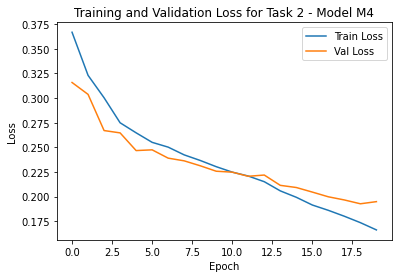

In [31]:
# Plot the training and validation loss
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training and Validation Loss for Task 2 - Model M4")

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.show()

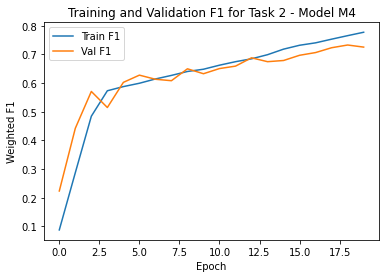

In [32]:
# Plot the training and validation F1 scores
plt.plot(train_f1s, label="Train F1")
plt.plot(val_f1s, label="Val F1")

plt.xlabel("Epoch")
plt.ylabel("Weighted F1")
plt.title("Training and Validation F1 for Task 2 - Model M4")

plt.legend()
plt.show()

In [33]:
# Save the model
torch.save(model.state_dict(), "M4_Task2.pth")

In [36]:
# Run inference on a random sample from the validation set
# Pick a random sample from the validation set
# Print the predicted and true labels

sample_idx = 43
sample_embeddings, sample_labels = val_dataset[sample_idx]
sample_embeddings = sample_embeddings.unsqueeze(0)  # Add a batch dimension
sample_labels = sample_labels.unsqueeze(0)

model.eval()
with torch.no_grad():
    output = model(sample_embeddings)
    predictions = output.argmax(dim=-1)

    print("Predictions:", predictions[0])
    print("True labels:", sample_labels[0])

    # Calculate the F1 score
    weighted_f1_sample, macro_f1_sample, f1_sample = compute_metrics(predictions.cpu().numpy(), sample_labels.cpu().numpy())
    print("Weighted F1:", weighted_f1_sample)
    print("Macro F1:", macro_f1_sample)
    print("F1:", f1_sample)

Predictions: tensor([0, 0, 1, 0])
True labels: tensor([0, 0, 1, 0])
Weighted F1: 1.0
Macro F1: 1.0
F1: 1.0
